In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Getting the data

As always, let's import our last updated data.

In [2]:
from utils import load_datasets

gru_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "gru")
gru_train_set, gru_val_set, gru_test_set = load_datasets(folder=gru_data_folder)

grubert_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "grubert")
grubert_train_set, grubert_val_set, grubert_test_set = load_datasets(folder=grubert_data_folder)

In [3]:
seeds = [42, 69, 420, 1, 3]

# Training

We start by defining all the params that characterize our training.

In [4]:
from ModelOps import bce
from transformers import AutoTokenizer

# Model class and Session Name
MODEL_CLASS = 'grubert'
SESSION_NAME = 'hashtag_enrichment'

# Fixed params
MODEL_NAME = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
EPOCHS = 30
SEEDS = [42, 69, 420, 1, 3]
EMBEDDING_SIZE = 768 # TODO: CHECK
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 50

# Grid Search params
LOSS_FN = bce
LR = 'cosine'
BATCH_SIZE = 8
LABEL_SMOOTHING = 0.1
SCALE_GRAD_BY_FREQ = False # True
GRU_HIDDEN_SIZE = 32 # 128 256
NUM_GRU_LAYERS = 2
GRU_DROPOUT = 0.2

# Enrichment params
HASHTAG_SEGMENTATION = False #True
POS_TAGS_ENRICHMENT = 'italian'
NUM_POS_TAGS = 48
HASHTAG_ENRICHMENT = True

c:\Users\marcy\miniconda3\envs\MyTorch\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
import torch
torch.cuda.is_available()

True

Let us set everything we need for training: model params, datasets and dataloader.

In [6]:
from gensim.models import KeyedVectors
from torch.utils.data import DataLoader
from CustomDataset import CustomDataset


# Model params
model_init_kwargs = {
    'embedding_size': EMBEDDING_SIZE,
    'gru_hidden_size': GRU_HIDDEN_SIZE, # 128, # 256,
    'num_gru_layers': NUM_GRU_LAYERS,
    'gru_dropout': GRU_DROPOUT,
    'text_enrichment': HASHTAG_ENRICHMENT,
    'num_tags': NUM_POS_TAGS
}

# Datasets
training_dataset = CustomDataset(
    parent_dir=parent_dir,
    dataframe=grubert_train_set,
    tokenizer=TOKENIZER,
    max_len=MAX_LEN,
    hashtag_segmentation=HASHTAG_SEGMENTATION,
    pos_tags=POS_TAGS_ENRICHMENT,
    text_enrichment=HASHTAG_ENRICHMENT
)

validation_dataset = CustomDataset(
    parent_dir=parent_dir,
    dataframe=grubert_val_set,
    tokenizer=TOKENIZER,
    max_len=MAX_LEN,
    hashtag_segmentation=HASHTAG_SEGMENTATION,
    pos_tags=POS_TAGS_ENRICHMENT,
    text_enrichment=HASHTAG_ENRICHMENT
)

# Dataloaders
training_loader = DataLoader(
    dataset=training_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True
)

Importato package text_enrichment.


In [8]:
from training_session import TrainingSession

ts = TrainingSession(
    model_class=MODEL_CLASS,
    model_init_kwargs=model_init_kwargs,
    training_loader=training_loader,
    validation_loader=validation_loader,
    loss_fn=LOSS_FN,
    lr=LR,
    session_name=SESSION_NAME,
    seeds=seeds
)

In [9]:
ts.train(EPOCHS, verbose=False)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\marcy\miniconda3\envs\MyTorch\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


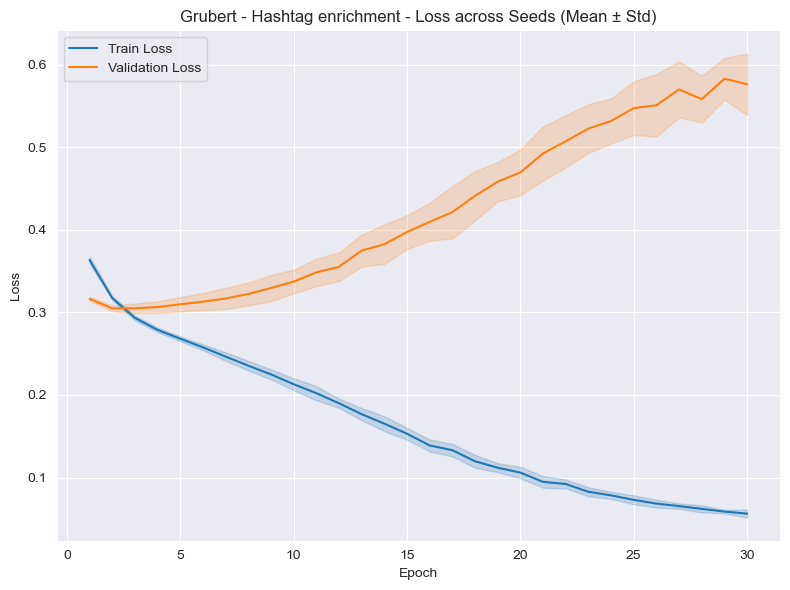

In [10]:
plot_folder = os.path.join(parent_dir, "6_training", "plots")

ts.plot(to_folder=plot_folder)